In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

# Load joined dataset
df = pd.read_csv("lea_absenteeism_x_graduation_2017_18.csv")

# Keep only reasonably sized LEAs
df = df[df["total_enrollment"] >= 100]

print("Shape:", df.shape)
df.head()

Shape: (3341, 6)


,LEAID,total_enrollment,num_schools_reporting,mean_school_absent_rate,weighted_absent_rate,grad_rate
0,100005,532.0,4,3.379832,2.819549,88.625000
1,100006,924.0,12,8.865099,8.982684,85.750000
2,100007,434.0,2,3.591439,2.995392,93.052632
3,100008,429.0,4,6.051376,5.128205,95.750000
4,100013,117.0,1,1.709402,1.709402,95.400000


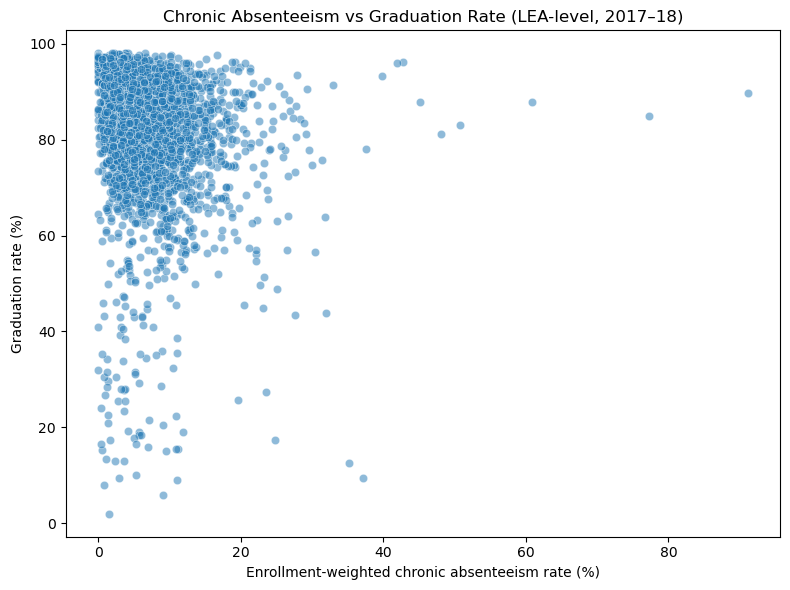

In [2]:
# Scatter plot: absenteeism vs graduation
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="weighted_absent_rate",
    y="grad_rate",
    alpha=0.5
)

plt.xlabel("Enrollment-weighted chronic absenteeism rate (%)")
plt.ylabel("Graduation rate (%)")
plt.title("Chronic Absenteeism vs Graduation Rate (LEA-level, 2017–18)")
plt.tight_layout()
plt.show()

## Scatter Plot Interpretation

The scatter plot shows a **negative association** between enrollment-weighted chronic absenteeism and graduation rates at the LEA level, but with **substantial dispersion**. Most districts cluster below 20% absenteeism, where graduation rates range widely from roughly 60% to over 95%. This spread indicates that while absenteeism is related to outcomes, it does **not deterministically predict graduation success**.

At higher absenteeism levels (above ~20%), the density of districts drops sharply, but graduation outcomes become more variable. A small number of districts exhibit **very high absenteeism alongside relatively high graduation rates**, suggesting that some systems may mitigate attendance risk through alternative supports or pathways.

Overall, the visual pattern supports interpreting absenteeism as a **risk indicator rather than a precise predictor**.

In [3]:
# Correlation
corr, pval = pearsonr(df["weighted_absent_rate"], df["grad_rate"])

print(f"Pearson correlation: {corr:.3f}")
print(f"P-value: {pval:.3e}")

Pearson correlation: -0.164
P-value: 1.677e-21


In [4]:
# Regression
X = df["weighted_absent_rate"]
y = df["grad_rate"]

X = sm.add_constant(X)  # adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              grad_rate   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     91.95
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           1.68e-21
Time:                        21:13:31   Log-Likelihood:                -13242.
No. Observations:                3341   AIC:                         2.649e+04
Df Residuals:                    3339   BIC:                         2.650e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   85.1611 

## Correlation and Regression Results

The Pearson correlation between chronic absenteeism and graduation rate is **−0.164 (p < 0.001)**, indicating a statistically significant but **modest linear relationship**. This aligns with the visual dispersion observed in the scatter plot.

The simple linear regression estimates that a **one percentage point increase in chronic absenteeism is associated with a ~0.38 percentage point decrease in graduation rate**, on average. However, the model explains only **~2.7% of the total variance (R² = 0.027)**, reinforcing that absenteeism alone captures a limited share of the factors influencing graduation outcomes.

These results suggest absenteeism provides **signal**, but most variation in graduation outcomes is driven by other contextual, structural, or programmatic factors not captured here.

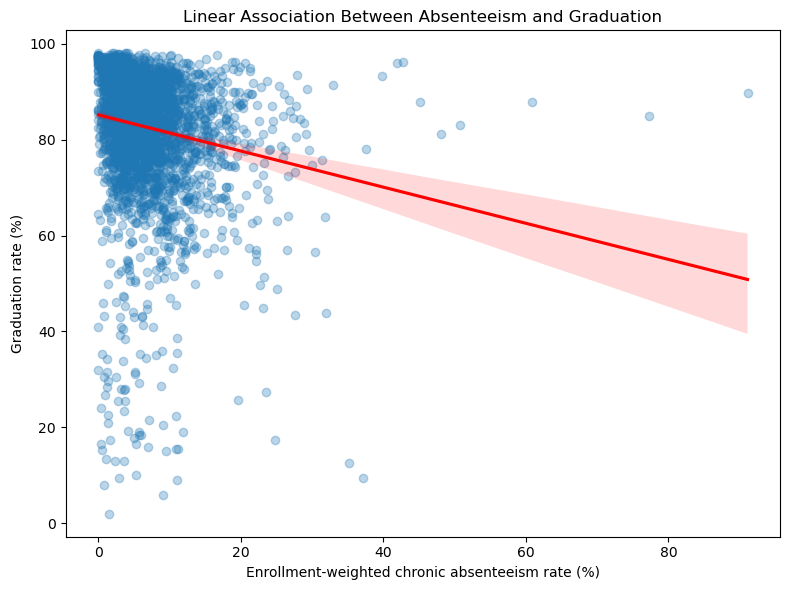

In [5]:
# Visualize the fitted relationship
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df,
    x="weighted_absent_rate",
    y="grad_rate",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)

plt.xlabel("Enrollment-weighted chronic absenteeism rate (%)")
plt.ylabel("Graduation rate (%)")
plt.title("Linear Association Between Absenteeism and Graduation")
plt.tight_layout()
plt.show()

In [6]:
# Bin-based view
df["absent_bin"] = pd.cut(
    df["weighted_absent_rate"],
    bins=[0, 5, 10, 15, 20, 100],
    right=False
)

bin_summary = (
    df.groupby("absent_bin")
      .agg(
          mean_grad_rate=("grad_rate", "mean"),
          count=("LEAID", "count")
      )
      .reset_index()
)

bin_summary

/var/folders/3s/m47q3wjj27l75f4v048s8kl40000gn/T/ipykernel_7182/3787529610.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("absent_bin")


,absent_bin,mean_grad_rate,count
0,"[0, 5)",84.755004,1558
1,"[5, 10)",81.931725,1182
2,"[10, 15)",79.202989,375
3,"[15, 20)",79.803762,137
4,"[20, 100)",74.708446,89


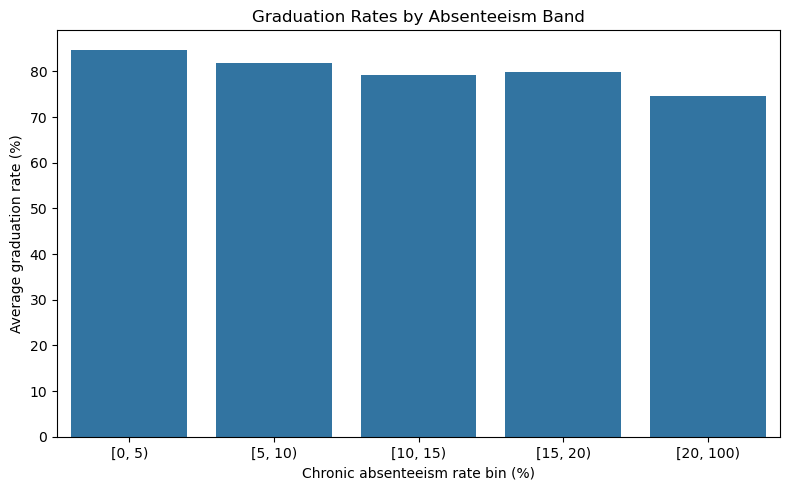

In [7]:
# Bar plot: graduation rates by absenteeism
plt.figure(figsize=(8, 5))
sns.barplot(
    data=bin_summary,
    x="absent_bin",
    y="mean_grad_rate"
)

plt.xlabel("Chronic absenteeism rate bin (%)")
plt.ylabel("Average graduation rate (%)")
plt.title("Graduation Rates by Absenteeism Band")
plt.tight_layout()
plt.show()

## Absenteeism Band Comparison

Binning districts by absenteeism rate clarifies the average relationship while preserving interpretability. Mean graduation rates decline monotonically across bands, from **~85% among districts with under 5% absenteeism** to **~75% among districts above 20% absenteeism**.

Notably, the largest drop occurs between the **lowest absenteeism band (0–5%) and the 5–10% band**, after which declines are more gradual. Even among high-absenteeism districts, average graduation rates remain well above zero, highlighting again that absenteeism is neither sufficient nor necessary to determine outcomes on its own.

This banded view reinforces absenteeism’s value as an **early warning signal**—useful for stratifying risk—while underscoring the need for additional indicators to guide intervention.

## Overall Interpretation

Across multiple views—scatter plots, regression results, and absenteeism bands—districts with **higher chronic absenteeism** tend to have **lower graduation rates on average**, but the relationship is **weak to moderate and highly variable**. Chronic absenteeism appears to function best as an **early risk signal** that helps stratify districts by likelihood of lower graduation outcomes, rather than as a precise or sufficient predictor.

## Limitations and Caution

This analysis is **correlational** and conducted at the **district (LEA) level**, which may mask important within-district variation. The results do **not establish causality** and should not be used to attribute graduation outcomes to absenteeism alone. Other structural, programmatic, and contextual factors likely account for the majority of observed variation in graduation rates.